In [430]:
import yfinance as yf
import xgboost as xgb
import pandas as pd

import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [431]:
crypto_btc = yf.download(tickers='BTC-USD', start='2018-01-01', end='2022-12-31').drop(columns=['Adj Close', 'High', 'Low']).round(2).reset_index()
crypto_eth = yf.download(tickers='ETH-USD', start='2018-01-01', end='2022-12-31').drop(columns=['Adj Close', 'High', 'Low']).round(2).reset_index()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [432]:
crypto_btc.head()

,Date,Open,Close,Volume
0,2018-01-01 00:00:00+00:00,14112.2,13657.2,10291200000
1,2018-01-02 00:00:00+00:00,13625.0,14982.1,16846600192
2,2018-01-03 00:00:00+00:00,14978.2,15201.0,16871900160
3,2018-01-04 00:00:00+00:00,15270.7,15599.2,21783199744
4,2018-01-05 00:00:00+00:00,15477.2,17429.5,23840899072


In [433]:
crypto_eth.head()

,Date,Open,Close,Volume
0,2018-01-01 00:00:00+00:00,755.76,772.64,2595760128
1,2018-01-02 00:00:00+00:00,772.35,884.44,5783349760
2,2018-01-03 00:00:00+00:00,886.00,962.72,5093159936
3,2018-01-04 00:00:00+00:00,961.71,980.92,6502859776
4,2018-01-05 00:00:00+00:00,975.75,997.72,6683149824


In [434]:
crypto_btc.shape


(1825, 4)

In [435]:
crypto_eth.shape

(1825, 4)

<AxesSubplot:title={'center':'Bitcoin Close price'}, xlabel='Date'>

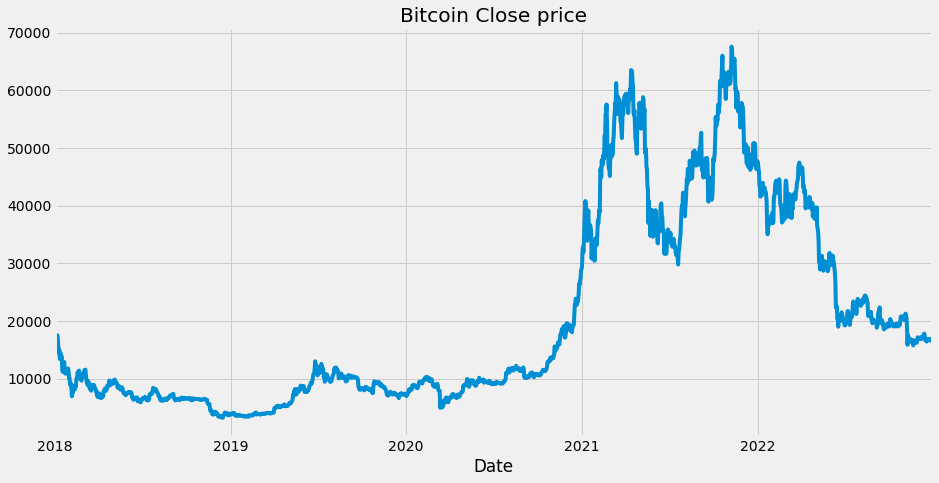

In [436]:
crypto_btc.set_index('Date').Close.plot(figsize=(14,7), title ='Bitcoin Close price', grid=True)

<AxesSubplot:title={'center':'Eth Close price'}, xlabel='Date'>

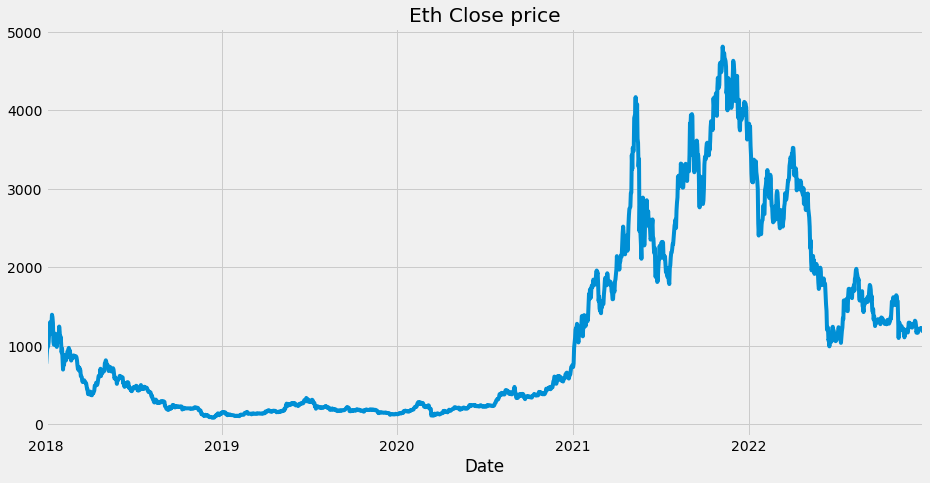

In [437]:
crypto_eth.set_index('Date').Close.plot(figsize=(14,7), title ='Eth Close price', grid=True)

In [438]:
missing_values = crypto_btc.isnull().sum()
missing_per = (missing_values/crypto_btc.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True) 
missing_table.rename(columns={0:'Total Missing Values',1:'Missing %'}, inplace=True)
missing_table

,Total Missing Values,Missing %
Date,0,0.0
Open,0,0.0
Close,0,0.0
Volume,0,0.0


In [439]:
missing_values = crypto_eth.isnull().sum()
missing_per = (missing_values/crypto_btc.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True) 
missing_table.rename(columns={0:'Total Missing Values',1:'Missing %'}, inplace=True)
missing_table

,Total Missing Values,Missing %
Date,0,0.0
Open,0,0.0
Close,0,0.0
Volume,0,0.0


In [440]:
crypto_btc

,Date,Open,Close,Volume
0,2018-01-01 00:00:00+00:00,14112.20,13657.20,10291200000
1,2018-01-02 00:00:00+00:00,13625.00,14982.10,16846600192
2,2018-01-03 00:00:00+00:00,14978.20,15201.00,16871900160
3,2018-01-04 00:00:00+00:00,15270.70,15599.20,21783199744
4,2018-01-05 00:00:00+00:00,15477.20,17429.50,23840899072
...,...,...,...,...
1820,2022-12-26 00:00:00+00:00,16842.25,16919.80,11886957804
1821,2022-12-27 00:00:00+00:00,16919.29,16717.17,15748580239
1822,2022-12-28 00:00:00+00:00,16716.40,16552.57,17005713920
1823,2022-12-29 00:00:00+00:00,16552.32,16642.34,14472237479


In [441]:
crypto_btc = crypto_btc.drop(columns=['Open','Volume'])
crypto_btc = crypto_btc.set_index('Date')
crypto_btc

,Close
Date,
2018-01-01 00:00:00+00:00,13657.20
2018-01-02 00:00:00+00:00,14982.10
2018-01-03 00:00:00+00:00,15201.00
2018-01-04 00:00:00+00:00,15599.20
2018-01-05 00:00:00+00:00,17429.50
...,...
2022-12-26 00:00:00+00:00,16919.80
2022-12-27 00:00:00+00:00,16717.17
2022-12-28 00:00:00+00:00,16552.57


In [442]:
# plot time series with range slider
crypto_btc.reset_index(inplace=True)
fig = px.line(crypto_btc, x='Date', y='Close', title='Close Price with Range Slider')
fig.update_layout(hovermode="x")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(step="all")
            
        ])
    )
)
fig.show()

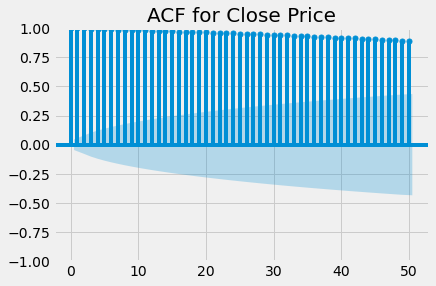

In [443]:
# ACF Plot
acf = plot_acf(crypto_btc.Close, lags=50, alpha=0.05)
plt.title("ACF for Close Price", size=20)
plt.show()

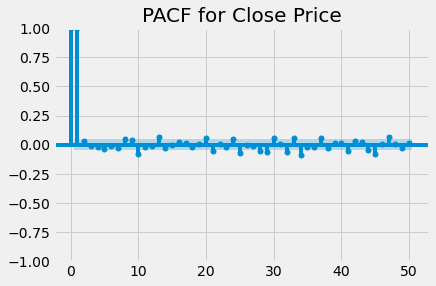

In [444]:
plot_pacf(crypto_btc.Close, lags=50, alpha=0.05, method='ols')
plt.title("PACF for Close Price", size=20)
plt.show()

In [445]:
# Feature Engineering

rolling_features = ["Close"]
window1 = 3 
window2 = 7
window3 = 30

# First convert our original df to a rolling df of 3d, 7d  and 30d
crypto_btc_rolled_3d = crypto_btc[rolling_features].rolling(window=window1, min_periods=0)
crypto_btc_rolled_7d = crypto_btc[rolling_features].rolling(window=window2, min_periods=0)
crypto_btc_rolled_30d = crypto_btc[rolling_features].rolling(window=window3, min_periods=0)


crypto_btc_mean_3d = crypto_btc_rolled_3d.mean().shift(1).reset_index()
crypto_btc_mean_7d = crypto_btc_rolled_7d.mean().shift(1).reset_index()
crypto_btc_mean_30d = crypto_btc_rolled_30d.mean().shift(1).reset_index()


# Just print to see the structure of one of them
crypto_btc_mean_30d

,index,Close
0,0,NaN
1,1,13657.200000
2,2,14319.650000
3,3,14613.433333
4,4,14859.875000
...,...,...
1820,1820,16939.856000
1821,1821,16955.040000
1822,1822,16964.124667
1823,1823,16975.299667


In [446]:
crypto_btc_std_3d = crypto_btc_rolled_3d.std().shift(1).reset_index()
crypto_btc_std_7d = crypto_btc_rolled_7d.std().shift(1).reset_index()
crypto_btc_std_30d = crypto_btc_rolled_30d.std().shift(1).reset_index()

# Just print to see the structure of one of them
crypto_btc_std_30d

,index,Close
0,0,NaN
1,1,NaN
2,2,936.845774
3,3,835.323855
4,4,841.493479
...,...,...
1820,1820,359.704649
1821,1821,348.373001
1822,1822,338.003088
1823,1823,317.373387


In [447]:
for feature in rolling_features:
    crypto_btc[f"{feature}_mean_lag{window1}"] = crypto_btc_mean_3d[feature]
    crypto_btc[f"{feature}_mean_lag{window2}"] = crypto_btc_mean_7d[feature]
    crypto_btc[f"{feature}_mean_lag{window3}"] = crypto_btc_mean_30d[feature]
    
    crypto_btc[f"{feature}_std_lag{window1}"] = crypto_btc_std_3d[feature]
    crypto_btc[f"{feature}_std_lag{window2}"] = crypto_btc_std_7d[feature]
    crypto_btc[f"{feature}_std_lag{window3}"] = crypto_btc_std_30d[feature]

crypto_btc.fillna(crypto_btc.mean(), inplace=True)

crypto_btc.set_index("Date", drop=False, inplace=True)
crypto_btc.head()

c:\Users\robel\anaconda3\envs\dev\envs\dev\lib\site-packages\ipykernel_launcher.py:10: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



,Date,Close,Close_mean_lag3,Close_mean_lag7,Close_mean_lag30,Close_std_lag3,Close_std_lag7,Close_std_lag30
Date,,,,,,,,
2018-01-01 00:00:00+00:00,2018-01-01 00:00:00+00:00,13657.2,20341.296316,20339.057842,20326.635136,504.500635,775.873175,1631.801833
2018-01-02 00:00:00+00:00,2018-01-02 00:00:00+00:00,14982.1,13657.200000,13657.200000,13657.200000,504.500635,775.873175,1631.801833
2018-01-03 00:00:00+00:00,2018-01-03 00:00:00+00:00,15201.0,14319.650000,14319.650000,14319.650000,936.845774,936.845774,936.845774
2018-01-04 00:00:00+00:00,2018-01-04 00:00:00+00:00,15599.2,14613.433333,14613.433333,14613.433333,835.323855,835.323855,835.323855
2018-01-05 00:00:00+00:00,2018-01-05 00:00:00+00:00,17429.5,15260.766667,14859.875000,14859.875000,312.861221,841.493479,841.493479


In [448]:
crypto_btc["month"] = crypto_btc.Date.dt.month
crypto_btc["week"] = crypto_btc.Date.dt.week
crypto_btc["day"] = crypto_btc.Date.dt.day
crypto_btc["day_of_week"] = crypto_btc.Date.dt.dayofweek
crypto_btc.head()

c:\Users\robel\anaconda3\envs\dev\envs\dev\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,Date,Close,Close_mean_lag3,Close_mean_lag7,Close_mean_lag30,Close_std_lag3,Close_std_lag7,Close_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,2018-01-01 00:00:00+00:00,13657.2,20341.296316,20339.057842,20326.635136,504.500635,775.873175,1631.801833,1,1,1,0
2018-01-02 00:00:00+00:00,2018-01-02 00:00:00+00:00,14982.1,13657.200000,13657.200000,13657.200000,504.500635,775.873175,1631.801833,1,1,2,1
2018-01-03 00:00:00+00:00,2018-01-03 00:00:00+00:00,15201.0,14319.650000,14319.650000,14319.650000,936.845774,936.845774,936.845774,1,1,3,2
2018-01-04 00:00:00+00:00,2018-01-04 00:00:00+00:00,15599.2,14613.433333,14613.433333,14613.433333,835.323855,835.323855,835.323855,1,1,4,3
2018-01-05 00:00:00+00:00,2018-01-05 00:00:00+00:00,17429.5,15260.766667,14859.875000,14859.875000,312.861221,841.493479,841.493479,1,1,5,4


In [449]:
crypto_btc_train = crypto_btc[crypto_btc.Date < "06-30-2021"]
crypto_btc_valid = crypto_btc[crypto_btc.Date >= "06-30-2021"]

print('train shape :', crypto_btc_train.shape)
print('validation shape :', crypto_btc_valid.shape)

train shape : (1276, 12)
validation shape : (549, 12)


In [450]:
# Model Building 
features = ['Close_mean_lag3', 'Close_mean_lag7',
       'Close_mean_lag30', 'Close_std_lag3', 'Close_std_lag7',
       'Close_std_lag30','month', 'week',
       'day', 'day_of_week']

XGBOOST

In [451]:
X_train, y_train = crypto_btc_train[features], crypto_btc_train.Close
X_test, y_test = crypto_btc_valid[features], crypto_btc_valid.Close

In [452]:
reg = xgb.XGBRegressor()

In [453]:
## Hyper Parameter Optimization Grid

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "max_depth"        : [1, 3, 4, 5, 6, 7],
 "n_estimators"     : [int(x) for x in np.linspace(start=100, stop=2000, num=10)],
 "min_child_weight" : [int(x) for x in np.arange(3, 15, 1)],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "subsample"        : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bytree" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bylevel": [0.5, 0.6, 0.7, 0.8, 0.9, 1],  
 
}

In [454]:
model  = RandomizedSearchCV(    
                reg,
                param_distributions=params,
                n_iter=10,
                n_jobs=-1,
                cv=5,
                verbose=3,
)

In [455]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                                                              0.8, 0.9, 1],
                              

In [456]:
print(f"Model Best Score : {model.best_score_}")
print(f"Model Best Parameters : {model.best_estimator_.get_params()}")

Model Best Score : -0.10147448351188926
Model Best Parameters : {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 0.9, 'colsample_bynode': 1, 'colsample_bytree': 0.9, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': 0.1, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.15, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 7, 'max_leaves': 0, 'min_child_weight': 8, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1788, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 0.6, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


In [457]:
model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.9, colsample_bynode=1, colsample_bytree=0.9,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=8,
             missing=nan, monotone_constraints='()', n_estimators=1788,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

c:\Users\robel\anaconda3\envs\dev\envs\dev\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:xlabel='Date'>

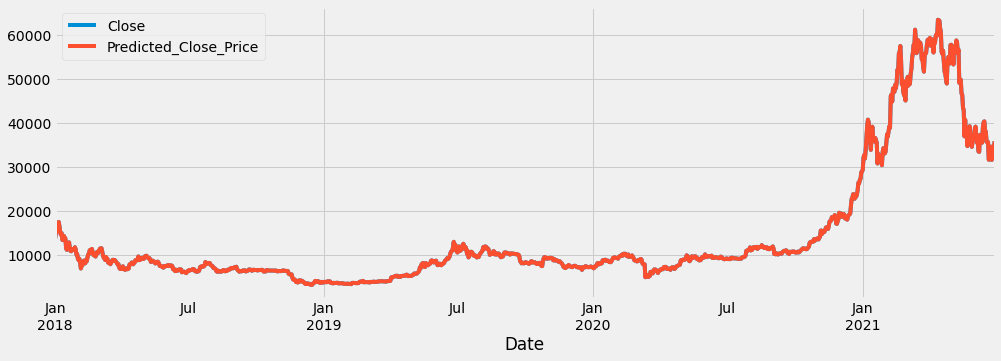

In [458]:
crypto_btc_train['Predicted_Close_Price'] = model.predict(X_train)

crypto_btc_train[['Close','Predicted_Close_Price']].plot(figsize=(15, 5))

In [459]:
crypto_btc_valid['Forecast_XGBoost'] = model.predict(X_test)

overall_data = pd.concat([crypto_btc_train, crypto_btc_valid], sort=False)

c:\Users\robel\anaconda3\envs\dev\envs\dev\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:xlabel='Date'>

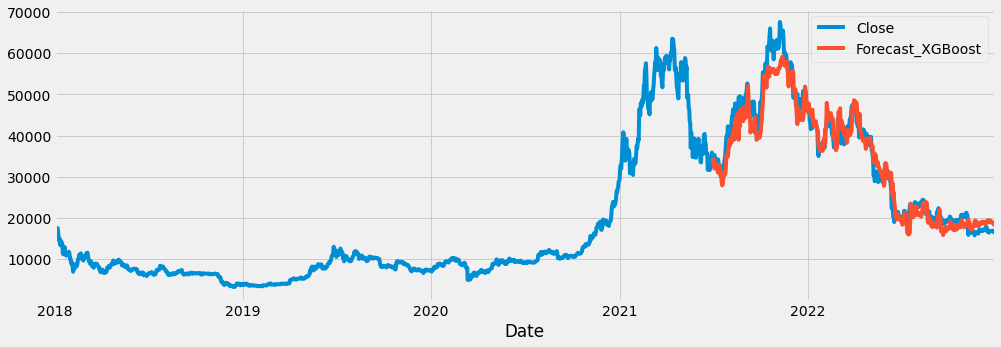

In [460]:
overall_data[['Close','Forecast_XGBoost']].plot(figsize=(15, 5))

<AxesSubplot:xlabel='Date'>

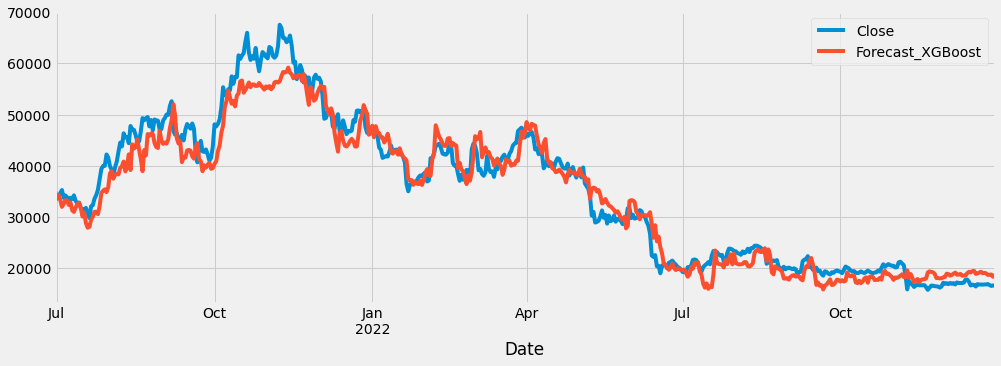

In [461]:
crypto_btc_valid[['Close','Forecast_XGBoost']].plot(figsize=(15, 5))

In [462]:
train_mae_xgboost = mean_absolute_error(crypto_btc_train['Close'], crypto_btc_train['Predicted_Close_Price'])
train_rmse_xgboost = np.sqrt(mean_squared_error(crypto_btc_train['Close'], crypto_btc_train['Predicted_Close_Price']))
train_r_square_xgboost = r2_score(crypto_btc_train['Close'], crypto_btc_train['Predicted_Close_Price'])
# train_accuracy_xgboost = accuracy_score(crypto_btc_train['Close'], crypto_btc_train['Predicted_Close_Price'])

print(f"train MAE : {train_mae_xgboost}")
print(f"train RMSE : {train_rmse_xgboost}")
print(f"train R2 : {train_r_square_xgboost}")
# print(f"train Accuracy: {train_accuracy_xgboost}")

train MAE : 0.19107817551187312
train RMSE : 0.2579822891848951
train R2 : 0.9999999996568479


In [463]:
test_mae_xgboost = mean_absolute_error(crypto_btc_valid['Close'], crypto_btc_valid['Forecast_XGBoost'])
test_rmse_xgboost = np.sqrt(mean_squared_error(crypto_btc_valid['Close'], crypto_btc_valid['Forecast_XGBoost']))
test_r2_xgboost = r2_score(crypto_btc_valid['Close'], crypto_btc_valid['Forecast_XGBoost'])
# test_accuracy_xgboost = accuracy_score(crypto_btc_valid['Close'], crypto_btc_valid['Forecast_XGBoost'])

print(f"test MAE XGBOOST : {test_mae_xgboost}")
print(f"test RMSE XGBOOST : {test_rmse_xgboost}")
print(f"test R2 XGBOOST : {test_r2_xgboost}")
# print(f"test accuracy score: {test_accuracy_xgboost}")

test MAE XGBOOST : 2511.7090885416665
test RMSE XGBOOST : 3201.4345710921702
test R2 XGBOOST : 0.9469758899159352
